In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/7/data

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/7/data


In [0]:
import numpy as np
# 데이터 부르기
x=np.loadtxt('segmentation/x_train.csv')
y=np.loadtxt('segmentation/y_train.csv')


In [0]:
x=x.T.reshape(-1,224,224,3).astype('int')
y=y.T.reshape(-1,224,224)

In [5]:
n_classes = len(set(np.array(y).flatten()))
n_classes

12

In [0]:
# 변환 함수 결정. filter 방향으로 one-hot coding 중.
def getsegnum(img):
  seg_labels = np.zeros((  224 , 224  , 12 ))
  for c in range(12):
    seg_labels[: , : , c ] = (img == c ).astype(int) # T,F 를 astype를 통해 0과 1로 변환.
  return seg_labels

  #img == 0 이면, img 에 들어있는 각 원소가 0이랑 같은지 다른지를 T,F로 바꿔서 출력함. 

In [0]:
y2 = []
for i in range(len(y)):
  y2.append(getsegnum(y[i]))

In [8]:
x = np.array(x)
y2 = np.array(y2)
print(x.shape, y2.shape)
print(np.unique(y2)) # 0. 과 1. 으로 나와있는거 확인. 실수이다.

(367, 224, 224, 3) (367, 224, 224, 12)
[0. 1.]


In [9]:
x = x/255
print(np.max(x))

1.0


In [0]:
# 1) 잔차연결o

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate,BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [12]:
base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
conv1 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output # 딱 여기까지가 18개 층임. conv만 층이아니라, pooling , bn , 등등도 전부 층으로 취급.
drop5 = Dropout(0.5)(conv5)

In [0]:
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

In [25]:
model = Model(inputs = base_vgg16.input, outputs = conv10)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [0]:
for layer in model.layers[:18]:
  layer.trainable = False

In [0]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='categorical_crossentropy', metrics = ['accuracy'])

In [28]:
history = model.fit(x,y2,epochs=50,batch_size=16,validation_split=0.1)

Epoch 1/50
21/21 [==============================] - 8s 392ms/step - loss: 1.2767 - accuracy: 0.6413 - val_loss: 7.2368 - val_accuracy: 0.4456
Epoch 2/50
21/21 [==============================] - 8s 373ms/step - loss: 0.7351 - accuracy: 0.7995 - val_loss: 3.8013 - val_accuracy: 0.6118
Epoch 3/50
21/21 [==============================] - 8s 373ms/step - loss: 0.6341 - accuracy: 0.8270 - val_loss: 1.6529 - val_accuracy: 0.6958
Epoch 4/50
21/21 [==============================] - 8s 373ms/step - loss: 0.5811 - accuracy: 0.8388 - val_loss: 1.9631 - val_accuracy: 0.6426
Epoch 5/50
21/21 [==============================] - 8s 373ms/step - loss: 0.5374 - accuracy: 0.8490 - val_loss: 1.2433 - val_accuracy: 0.7345
Epoch 6/50
21/21 [==============================] - 8s 374ms/step - loss: 0.4917 - accuracy: 0.8614 - val_loss: 1.0311 - val_accuracy: 0.7390
Epoch 7/50
21/21 [==============================] - 8s 373ms/step - loss: 0.4622 - accuracy: 0.8698 - val_loss: 0.7097 - val_accuracy: 0.8141
Epoch 

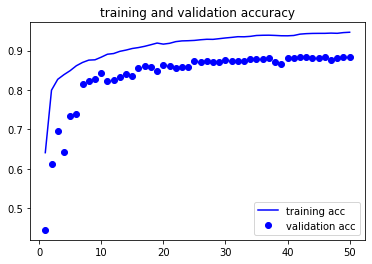

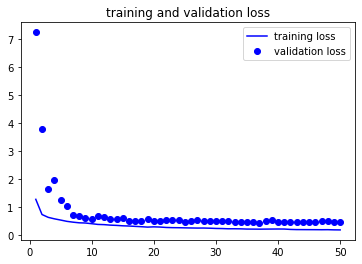

In [29]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# 약간의 오버피팅이 있다.

In [30]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)
#np.mean(y_predi == y_testi)
y_predi.shape

(2, 224, 224)

In [31]:
np.mean(y_predi == y_testi)

0.882453762755102

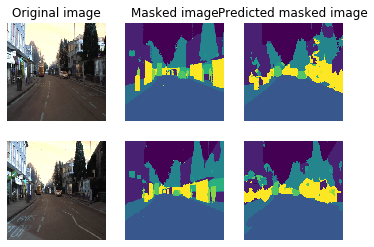

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y[-1])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis('off')
plt.title('Predicted masked image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis('off')
plt.grid('off')
plt.show()

In [0]:
from tensorflow.keras.utils import plot_model

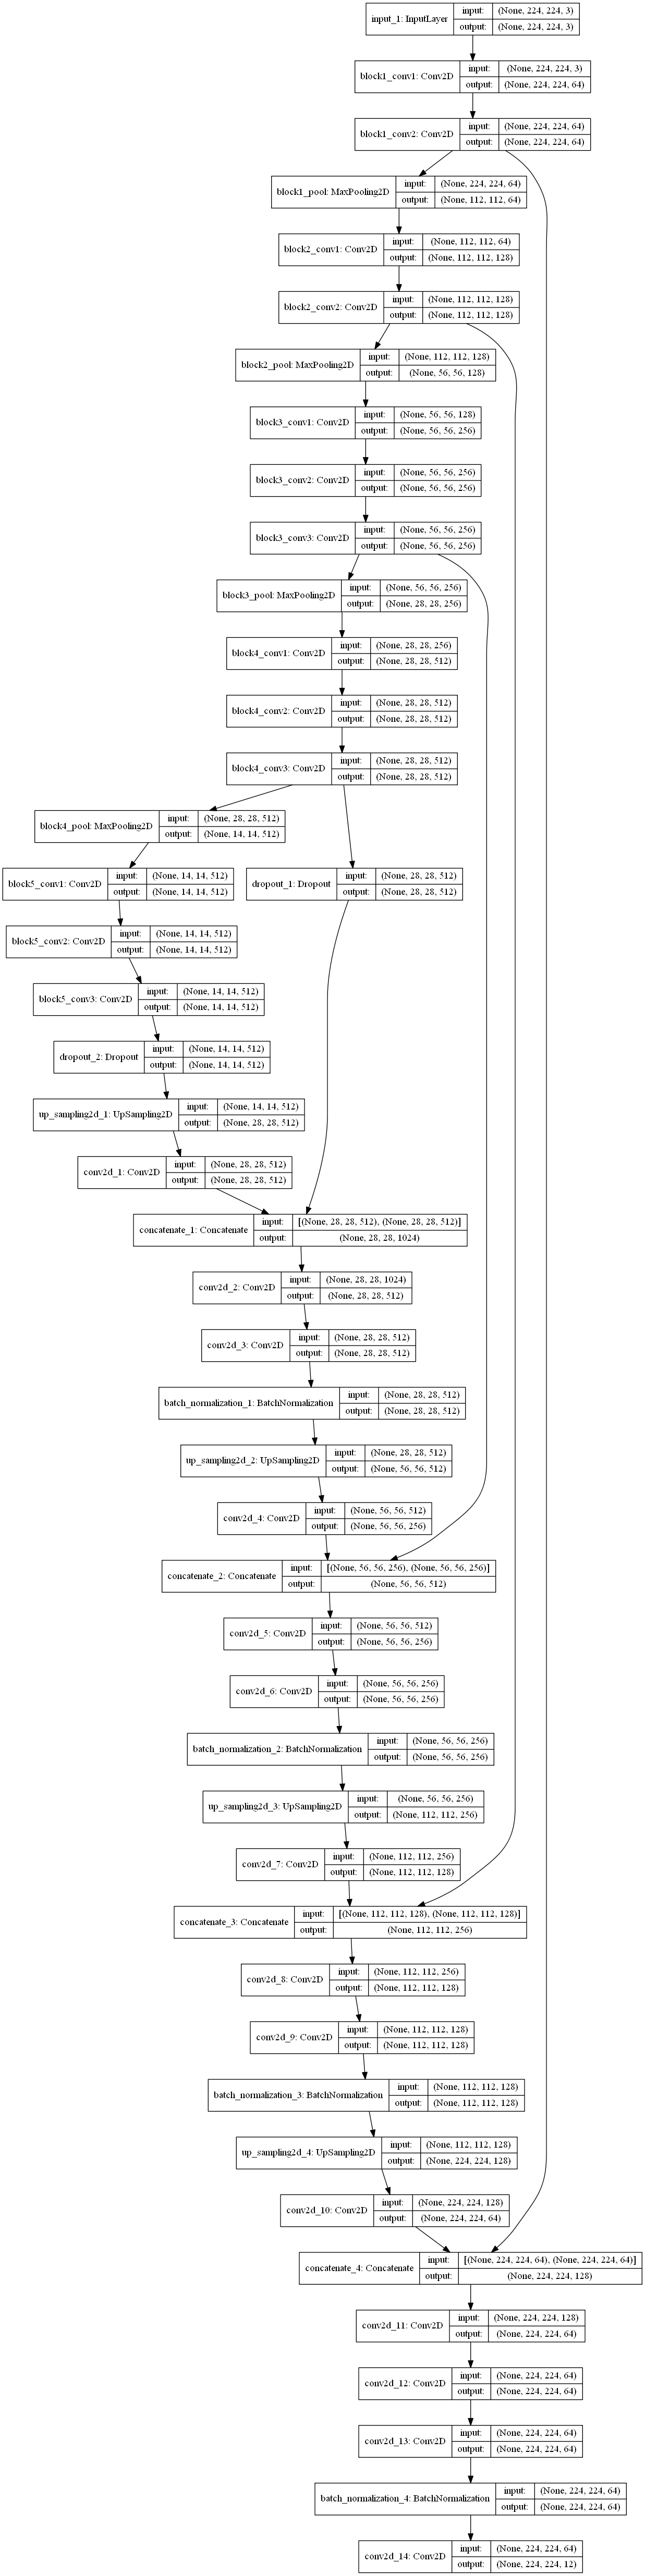

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# 2) 잔차연결 x

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False

In [0]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate,BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [47]:
base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
conv1 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output # 딱 여기까지가 18개 층임. conv만 층이아니라, pooling , bn , 등등도 전부 층으로 취급.
drop5 = Dropout(0.5)(conv5)

In [0]:
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(drop5))

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(up6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv6))
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(up7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv7))
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(up8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv8))
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(up9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

In [50]:
model = Model(inputs = base_vgg16.input, outputs = conv10)
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [0]:
for layer in model.layers[:18]:
  layer.trainable = False

In [0]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='categorical_crossentropy', metrics = ['accuracy'])

In [55]:
history = model.fit(x,y2,epochs=50,batch_size=16,validation_split=0.1)

Epoch 1/50
21/21 [==============================] - 7s 350ms/step - loss: 1.4043 - accuracy: 0.5888 - val_loss: 8.5121 - val_accuracy: 0.3727
Epoch 2/50
21/21 [==============================] - 7s 333ms/step - loss: 0.9696 - accuracy: 0.7089 - val_loss: 2.3754 - val_accuracy: 0.6730
Epoch 3/50
21/21 [==============================] - 7s 334ms/step - loss: 0.8895 - accuracy: 0.7332 - val_loss: 1.9911 - val_accuracy: 0.6732
Epoch 4/50
21/21 [==============================] - 7s 333ms/step - loss: 0.8194 - accuracy: 0.7562 - val_loss: 1.3093 - val_accuracy: 0.7250
Epoch 5/50
21/21 [==============================] - 7s 333ms/step - loss: 0.7951 - accuracy: 0.7625 - val_loss: 1.2194 - val_accuracy: 0.7320
Epoch 6/50
21/21 [==============================] - 7s 333ms/step - loss: 0.7627 - accuracy: 0.7740 - val_loss: 1.2099 - val_accuracy: 0.7491
Epoch 7/50
21/21 [==============================] - 7s 334ms/step - loss: 0.7326 - accuracy: 0.7825 - val_loss: 1.0799 - val_accuracy: 0.7543
Epoch 

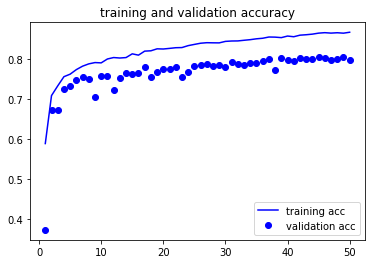

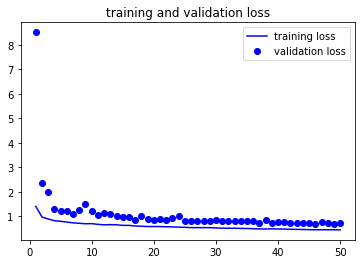

In [56]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# 약간의 오버피팅이 있다.

In [57]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)
#np.mean(y_predi == y_testi)
y_predi.shape

(2, 224, 224)

In [58]:
np.mean(y_predi == y_testi)

0.7980309311224489

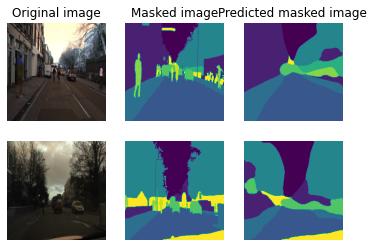

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y[-1])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis('off')
plt.title('Predicted masked image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis('off')
plt.grid('off')
plt.show()

In [0]:
from tensorflow.keras.utils import plot_model

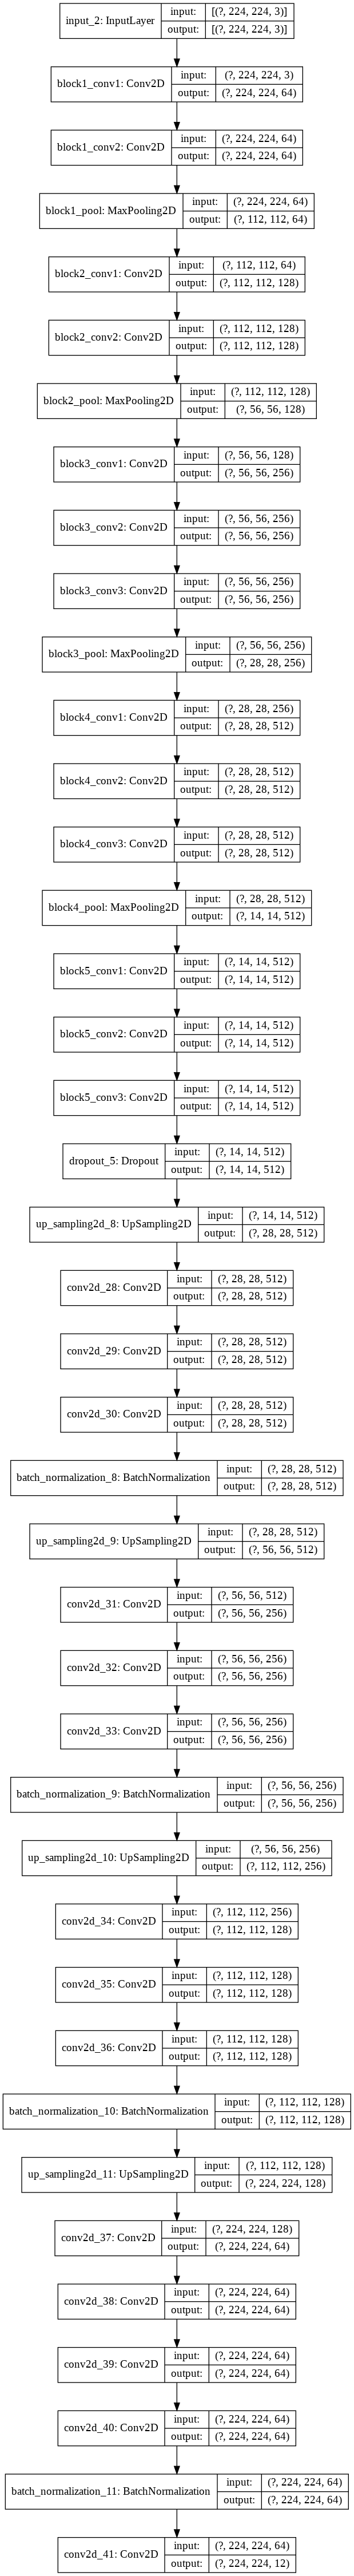

In [52]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# 과제에 대해 말해보자.

# 1. 잔차연결(보단, skip connection이 맞을듯) 을 생략하여 잔차연결 효과를 논의할 것

# 2. Upsampling 대신 Conv2DTranspose를 이용하여 차이점을 논의할 것

# 3. maxpooling 대신 stride를 써서 pixel size를 줄여서 차이점을 비교할 것

# 4. 4/30일 10시 이전 제출
